In [12]:
from collections import OrderedDict
from itertools import islice

od = OrderedDict()
od['a'] = 1
od['b'] = 2
od['c'] = 3
od['d'] = 4

# Slice using islice
for idx, (key, value) in islice(enumerate(od.items()), 5, None):
    print(key, value)

"OpenT" in ["OpenToM", "ToMi"]

False

In [1]:
from dotenv import load_dotenv
import os
import torch
from typing import Optional
from transformers import AutoModelForCausalLM, AutoTokenizer
# gc.collect()
load_dotenv()
hf_access_token = os.getenv("HF_ACCESS_TOKEN")
cache_dir = os.getenv("CACHE_DIR")
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model and tokenizer onto GPU
checkpoint = "HuggingFaceTB/SmolLM2-360M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token)
model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token).to(device)

In [2]:
print(type(tokenizer).__name__)
print(type(model).__name__)

GPT2TokenizerFast
LlamaForCausalLM


In [5]:
import torch
allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB
reserved_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert to GB
print(f"Allocated GPU memory: {allocated_memory:.2f} GB (actively used by tensors)")
print(f"Reserved GPU memory: {reserved_memory:.2f} GB (reserved by PyTorch but not actively used)")

Allocated GPU memory: 29.96 GB (actively used by tensors)
Reserved GPU memory: 30.21 GB (reserved by PyTorch but not actively used)


(131072,)


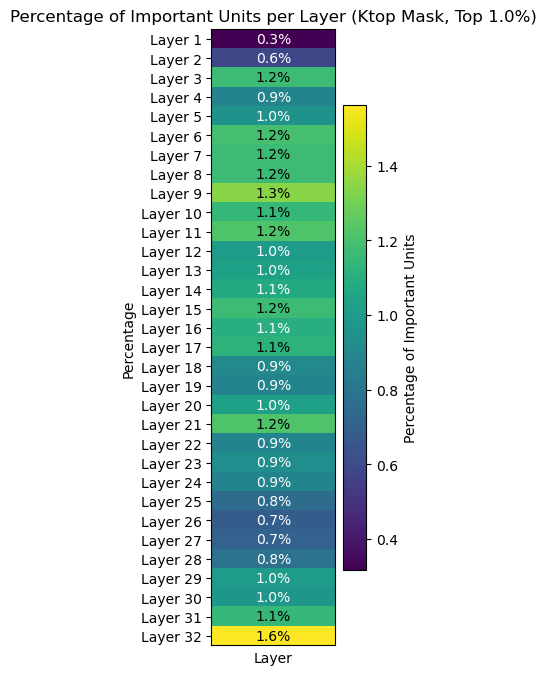

In [6]:
tom_data = ToMLocDataset()
llm = ImportLLMfromHF(model, tokenizer)
units = LayersUnits(llm, tom_data)
loc_units = LocImportantUnits(checkpoint, units.data_activation)
loc_units.plot_layer_percentages(0.01)

In [7]:
bn_open = BenchmarkOpenToM(order="first_order", subset=10)
bn_tomi = BenchmarkToMi(subset=20)
bn_assess = AssessBenchmark(llm, loc_units)
res = bn_assess.experiment(bn_open, batch_size=10)

100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


In [2]:
#res.to_csv("checkpoint/tomi-mistral-8B.csv", index=False)
import pandas as pd
res = pd.read_csv("checkpoint/opentom-llama-3-8B.csv")
res.head(3)

,index,plot,plot_info,preferences,personality,sentiment_statement,true_sentiment,intention,new_location,observed,...,type,is_closed_question,qOrder,cands,prompt,predict_no_ablation,predict_ablate_top_1,predict_ablate_random1_1,predict_ablate_random2_1,predict_ablate_random3_1
0,0,Diego entered the patio.\nAmir entered the pat...,"{'mover': 'Diego', 'eoi': 'scarf', 'original_p...","{'mover': 'Diego hates scarf.', 'observer': 'A...",Diego is an inconsiderate person.,Diego hates scarf.,the most negative,get rid of it and make it accessible to someon...,a donation bin,True,...,multihop-fo,False,first_order,"['less full', 'equally full', 'more full']",The following multiple choice question is base...,less full,less full,less full,less full,less full
1,1,Diego entered the patio.\nAmir entered the pat...,"{'mover': 'Diego', 'eoi': 'scarf', 'original_p...","{'mover': 'Diego hates scarf.', 'observer': 'A...",Diego is an inconsiderate person.,Diego hates scarf.,the most negative,get rid of it and make it accessible to someon...,a donation bin,True,...,multihop-fo,False,first_order,"['less full', 'equally full', 'more full']",The following multiple choice question is base...,less full,less full,less full,less full,less full
2,2,Diego entered the patio.\nAmir entered the pat...,"{'mover': 'Diego', 'eoi': 'scarf', 'original_p...","{'mover': 'Diego hates scarf.', 'observer': 'A...",Diego is an inconsiderate person.,Diego hates scarf.,the most negative,get rid of it and make it accessible to someon...,a donation bin,True,...,multihop-fo,False,first_order,"['less full', 'equally full', 'more full']",The following multiple choice question is base...,more full,less full,more full,less full,more full


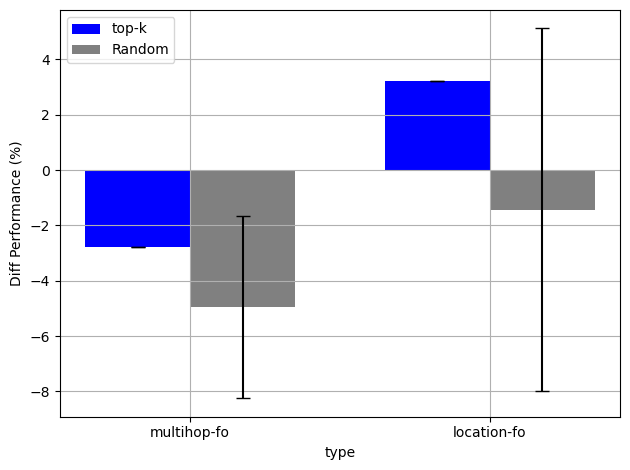

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import sem, t

def compute_diff(df, filter_variable):
    """
    Computes the difference in performance between ablation and no ablation
    for categories dynamically determined by the specified filter variable.

    Args:
        df (pd.DataFrame): Data frame containing the necessary columns.
        filter_variable (str): The column name to filter the data frame by.

    Returns:
        dict: Dictionary containing differences for each category defined by the filter variable values.
    """
    # Get unique values for the filter variable
    unique_values = df[filter_variable].unique()

    # Initialize result dictionary
    diff = {f"{value}": {"top_k": []} for value in unique_values}

    # Compute differences for each category
    for value in unique_values:
        category_df = df[df[filter_variable] == value]
        top_k_diff = (category_df["answer"] == category_df["predict_ablate_top_1"]).mean() - (
                category_df["answer"] == category_df["predict_no_ablation"]).mean()
        diff[f"{value}"]["top_k"].append(top_k_diff)

    # Handle random columns if they exist
    random_cols = [col for col in df.columns if col.startswith("predict_ablate_random")]
    if random_cols:
        for value in unique_values:
            diff[f"{value}"]["random"] = []
            category_df = df[df[filter_variable] == value]
            for random_col in random_cols:
                random_diff = (category_df["answer"] == category_df[random_col]).mean() - (
                        category_df["answer"] == category_df["predict_no_ablation"]).mean()
                diff[f"{value}"]["random"].append(random_diff)

    return diff

def compute_mean_and_std(values):
    """
    Computes the mean and standard deviation for a list of values.

    Args:
        values (list): List of numerical values.

    Returns:
        tuple: Mean and standard deviation.
    """
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

def barplot_diff(input_data, input_type="dataframe", filter_variable=None):
    """
    Plots a bar plot comparing differences across categories in the specified filter variable,
    with optional standard deviation error bars.

    Args:
        input_data: Either a pandas DataFrame or a JSON file path containing the data.
        input_type (str): Type of input, either "dataframe" or "json".
        filter_variable (str): The column name used for filtering categories in compute_diff.

    Returns:
        None
    """
    if filter_variable is None:
        raise ValueError("The filter_variable must be specified.")

    # Determine the source of data
    if input_type == "dataframe":
        # Compute differences from the DataFrame
        diff = compute_diff(input_data, filter_variable)
    elif input_type == "json":
        # Load differences from the JSON file
        with open(input_data, "r") as json_file:
            diff = json.load(json_file)
    else:
        raise ValueError("Invalid input_type. Must be 'dataframe' or 'json'.")

    # Extract categories dynamically
    categories = list(diff.keys())
    means_topk = []
    stds_topk = []
    means_random = []
    stds_random = []

    has_random = False  # Check if random values exist
    for category in categories:
        # Compute mean and std for "top_k"
        mean_topk, std_topk = compute_mean_and_std(diff[category]["top_k"])
        means_topk.append(mean_topk * 100)
        stds_topk.append(std_topk * 100)

        # Compute mean and std for "random" if present
        if "random" in diff[category]:
            has_random = True
            mean_random, std_random = compute_mean_and_std(diff[category]["random"])
            means_random.append(mean_random * 100)
            stds_random.append(std_random * 100)

    # Set up positions for the bars
    x = np.arange(len(categories))
    width = 0.35

    # Plotting
    fig, ax = plt.subplots()

    # Plot top-k bars with error bars
    bars1 = ax.bar(x - width / 2 if has_random else x, means_topk, width, yerr=stds_topk, label="top-k", color="blue", capsize=5)

    # Plot random bars with error bars if random values are present
    if has_random:
        bars2 = ax.bar(x + width / 2, means_random, width, yerr=stds_random, label="Random", color="grey", capsize=5)

    # Add labels, title, and legend
    ax.set_xlabel(filter_variable)
    ax.set_ylabel('Diff Performance (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)

    # Add legend dynamically based on what is plotted
    if has_random:
        ax.legend()
    else:
        ax.legend(["top-k"])

    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def save_diff(df, filter_variable, file_path="diff.json"):
    """
    Saves the computed differences in a JSON file.

    Args:
        df (pd.DataFrame): Data frame containing the necessary data.
        filter_variable (str): The column name used for filtering categories in compute_diff.
        file_path (str): Path to save the JSON file.

    Returns:
        None
    """
    if filter_variable is None:
        raise ValueError("The filter_variable must be specified.")

    # Compute differences
    diff = compute_diff(df, filter_variable)

    # Save to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(diff, json_file, indent=4)
    print(f"Diff saved to {file_path}")


barplot_diff(res, filter_variable="type")    